<h1>Segmentation</h1>

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
img1 = cv2.imread('plant.jpg')
image = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 =  cv2.imread('plant2.jpg')
image1 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

(np.float64(-0.5), np.float64(1535.5), np.float64(1919.5), np.float64(-0.5))

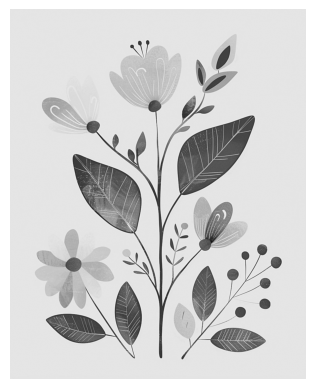

In [3]:
plt.imshow(image,cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

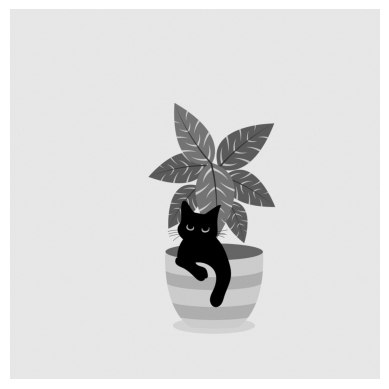

In [4]:
plt.imshow(image1,cmap='gray')
plt.axis('off')

<H2>Thresholding</H2>

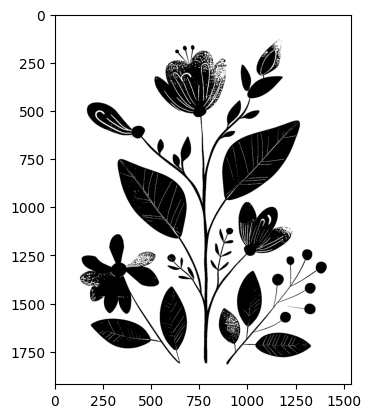

In [6]:
thresh = np.zeros_like(image)
for  i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if(image[i,j] > 200):
            thresh[i,j] = 255
            
plt.imshow(thresh,cmap = 'gray')


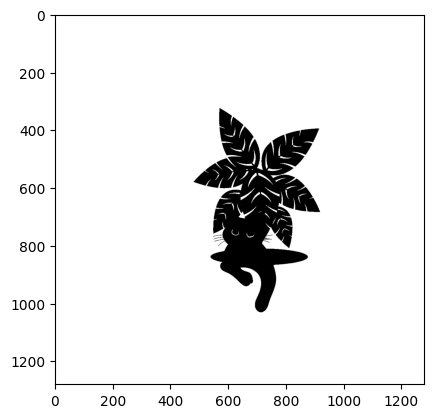

In [41]:
thresh = np.zeros_like(image1)
for  i in range(image1.shape[0]):
    for j in range(image1.shape[1]):
        if(image1[i,j] > 150):
            thresh[i,j] = 255
            
plt.imshow(thresh,cmap = 'gray')

<h4>Adaptive thresholding</h4>

In [15]:
mean_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, blockSize=25, C=2)


In [20]:
mean_thresh1 = cv2.adaptiveThreshold(image1, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, blockSize=21, C=2)

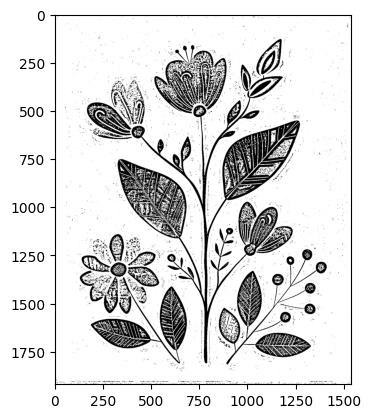

In [21]:
plt.imshow(mean_thresh,cmap = "gray")

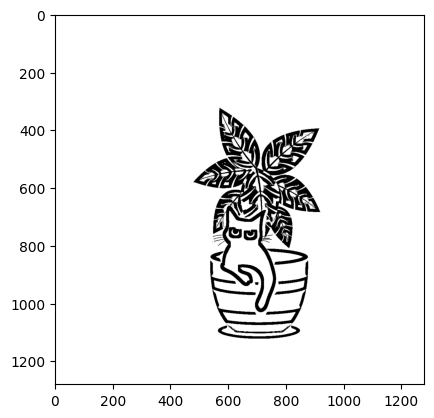

In [22]:
plt.imshow(mean_thresh1,cmap = "gray")

In [19]:
gaussian_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, blockSize=11, C=2)

In [47]:
gaussian_thresh1 = cv2.adaptiveThreshold(image1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, blockSize=11, C=2)

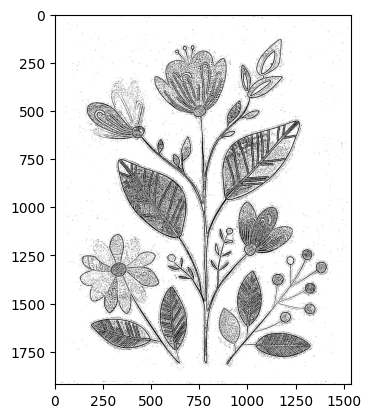

In [48]:
plt.imshow(gaussian_thresh,cmap = 'gray')

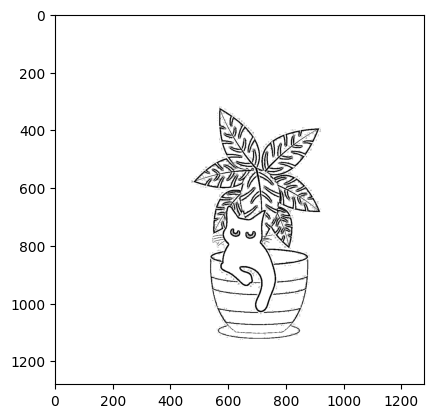

In [49]:
plt.imshow(gaussian_thresh1,cmap = 'gray')

<h2>Kmeans clustering</h2>

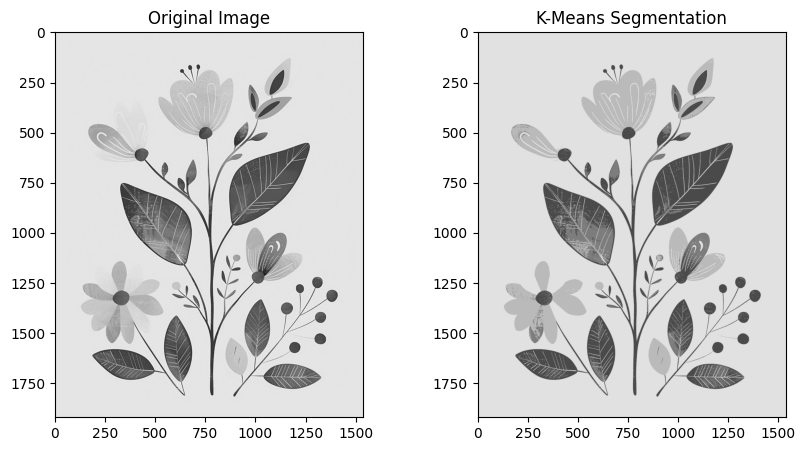

In [50]:
def initialize_centroids(data, k):
    np.random.seed(42)  # For reproducibility
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]

def assign_clusters(data, centroids):
    """ Assign each pixel to the nearest centroid based on Euclidean distance. """
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(data, labels, k):
    """ Compute new centroids as the mean of assigned pixels. """
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans_segmentation(image, k=3, max_iters=10):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB

    # Flatten the image (num_pixels, 3)
    data = image.reshape((-1, 3)).astype(np.float32)

    # Initialize K random centroids
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)

        # If centroids don't change, stop early
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    # Assign each pixel to its cluster centroid
    segmented_data = centroids[labels].astype(np.uint8)
    segmented_image = segmented_data.reshape(image.shape)

    return segmented_image


segmented = kmeans_segmentation(image, k=4)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title("K-Means Segmentation")

plt.show()


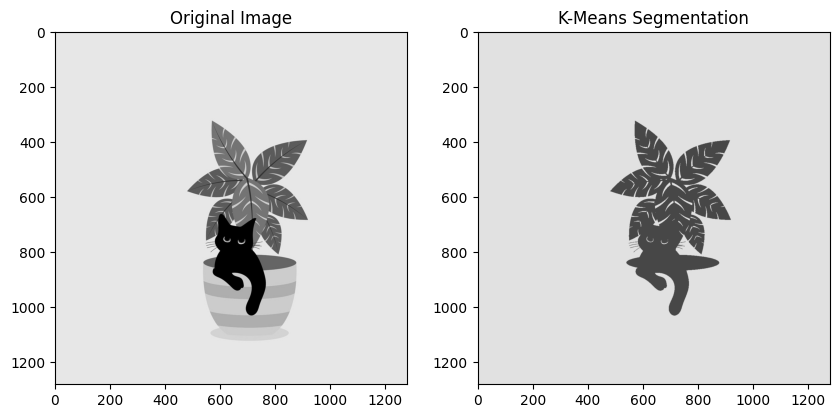

In [61]:
segmented1 = kmeans_segmentation(image1, k=2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented1, cv2.COLOR_BGR2RGB))
plt.title("K-Means Segmentation")

plt.show()

<h2>Region Growing</h2>

In [52]:
import numpy as np
from collections import deque

def region_growing(image, seeds, threshold):
    rows, cols = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=bool)

    queue = deque(seeds) 
    region_intensity = np.mean([image[y, x] for x, y in seeds])  

    for x_seed, y_seed in seeds:
        visited[y_seed, x_seed] = True

    while queue:
        x, y = queue.popleft()
        segmented[y, x] = 255  

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                
                new_x, new_y = x + dx, y + dy
                
                if 0 <= new_x < cols and 0 <= new_y < rows:
                    if not visited[new_y, new_x]:
                        neighbor_intensity = int(image[new_y, new_x])
                        
                        if abs(neighbor_intensity - region_intensity) <= threshold:
                            visited[new_y, new_x] = True
                            queue.append((new_x, new_y))
    
    return segmented


In [53]:
s_image = region_growing(image, [(150,150),(100,700)], 80)

In [54]:
s_image1 = region_growing(image1, [(150,150),(100,700),(200,1000),(500,500)], 80)

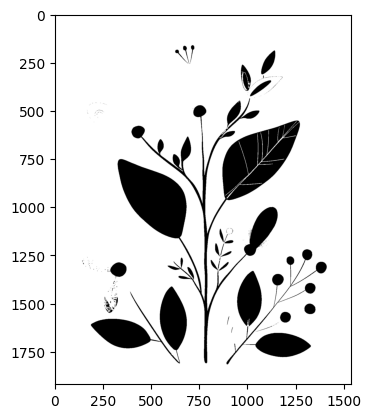

In [55]:
plt.imshow(s_image,cmap = 'gray')

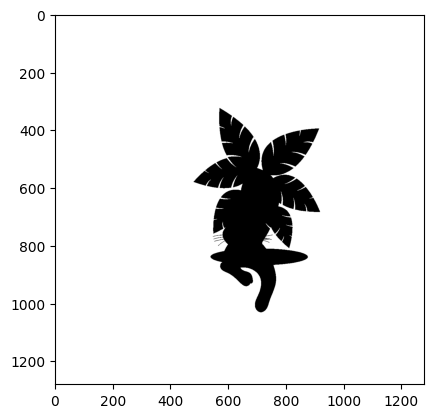

In [56]:
plt.imshow(s_image1,cmap = 'gray')

<h2>Graph cut segmentation</h2>

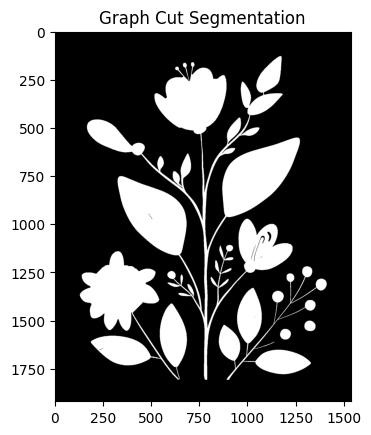

In [57]:

def graph_cut_segmentation(image, rect):

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    mask = np.zeros(image.shape[:2], np.uint8)  
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    cv2.grabCut(image, mask, rect, bgd_model, fgd_model ,5, cv2.GC_INIT_WITH_RECT)
    segmented_mask = np.where((mask == 2) | (mask == 0), 0, 255).astype(np.uint8)

    return segmented_mask

rect = (10, 10, 1750, 1800)

segmented = graph_cut_segmentation(image, rect)

plt.imshow(segmented, cmap='gray')
plt.title("Graph Cut Segmentation")

plt.show()


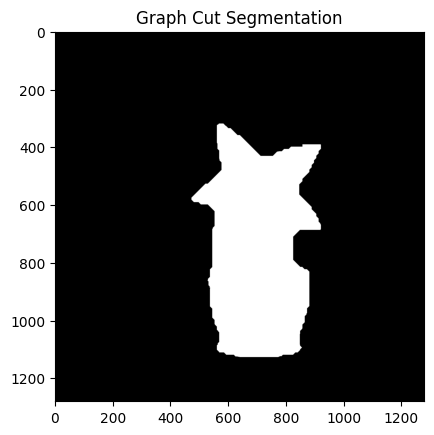

In [58]:

rect = (10, 10, 1750, 1800)

segmented1 = graph_cut_segmentation(image1, rect)

plt.imshow(segmented1, cmap='gray')
plt.title("Graph Cut Segmentation")

plt.show()

<h2>Mean shifting</h2>

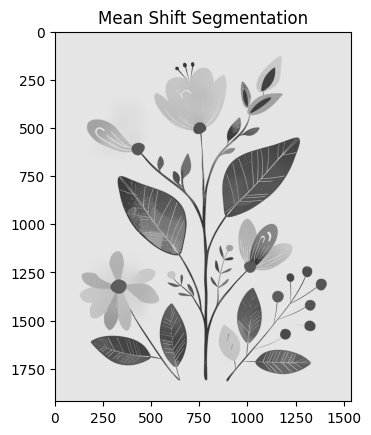

In [12]:
def mean_shift_segmentation(image, spatial_radius=30, color_radius=30, max_level=1):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  
    segmented = cv2.pyrMeanShiftFiltering(image, spatial_radius, color_radius, max_level)
    
    return segmented

segmented = mean_shift_segmentation(image)
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title("Mean Shift Segmentation")
plt.show()


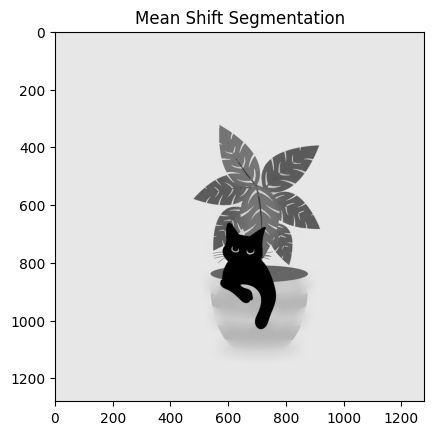

In [11]:
segmented1 = mean_shift_segmentation(image1)
plt.imshow(cv2.cvtColor(segmented1, cv2.COLOR_BGR2RGB))
plt.title("Mean Shift Segmentation")
plt.show()